In [1]:
import os
import cv2
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import tensorflow_hub as hub
import json
import matplotlib.image as mpimg
from skimage.transform import resize
from moviepy.editor import VideoFileClip

from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

2024-02-16 16:17:39.695662: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Convert video into frames

In [2]:
# convert video into frames

# !video-toimg output_1.avi

output_folder = "output_1/"
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

!ffmpeg -i output_1.avi -vf fps=24 output_1/%04d.png

ffmpeg version 6.1.1 Copyright (c) 2000-2023 the FFmpeg developers
  built with Apple clang version 15.0.0 (clang-1500.1.0.2.5)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/6.1.1_3 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags='-Wl,-ld_classic' --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libaribb24 --enable-libbluray --enable-libdav1d --enable-libharfbuzz --enable-libjxl --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libssh --enable-libsvtav1 --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libopenvin

In [3]:
DIRNAME = "output_1"

# IMG_SIZE = [448, 448]
IMG_SIZE = [896, 896]
video_path = "output_1.avi"

# define framerate
fps=24

# Image Loader

In [4]:
# Load all images into a list

test_images = []
test_images_size_tups = []

for file in os.listdir(DIRNAME):
    img = cv2.imread(f"{DIRNAME}/{file}")
    test_images_size_tups.append(img.shape)

    img = cv2.resize(img, IMG_SIZE)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    test_images.append(img)

In [5]:
def frame_index_to_time_stamp(frame_index, frame_rate):
    return frame_index / frame_rate

# Image Annotation with detection

In [6]:
# Annotate the images with detected boxes

# Adjust threshold carefully to the optimal result

def get_annotated_img_objects(img, boxes, scores, num_detections, score_threshold=0.2):
    image = np.array(img)
    objects = 0
    box_list = []

    for i in range(num_detections):
        if scores[i] >= score_threshold:
            box = boxes[i]
            y_min, x_min, y_max, x_max = box
            
            cv2.rectangle(image, (int(x_min), int(y_min)), (int(x_max), int(y_max)), (0, 255, 0), 2)

            box_list.append((int(x_min), int(y_min), int(x_max), int(y_max)))
            objects += 1

    return image, objects, box_list

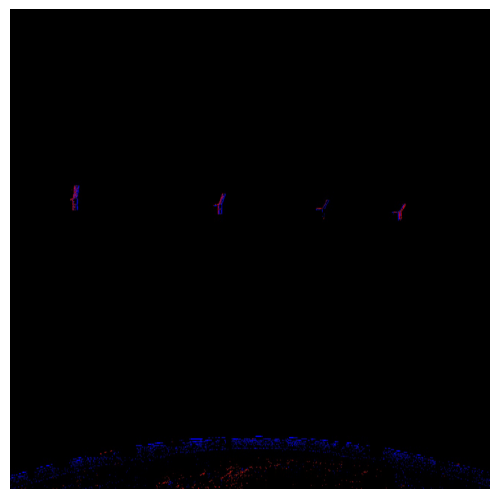

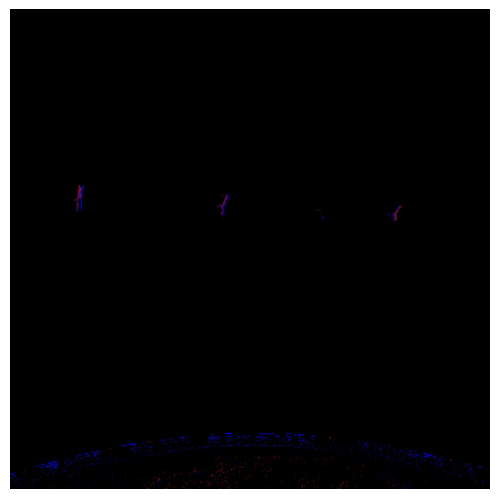

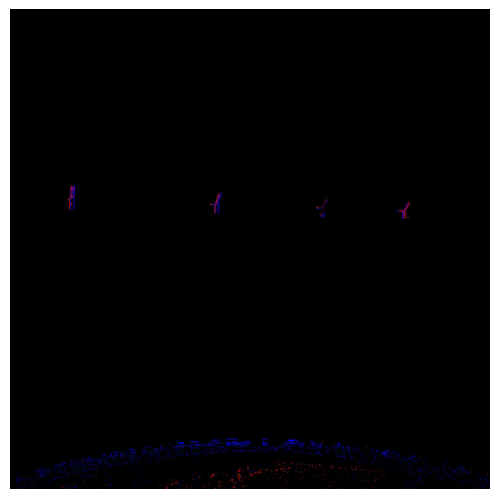

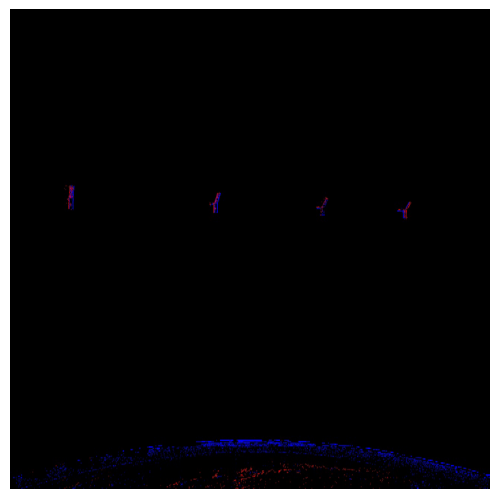

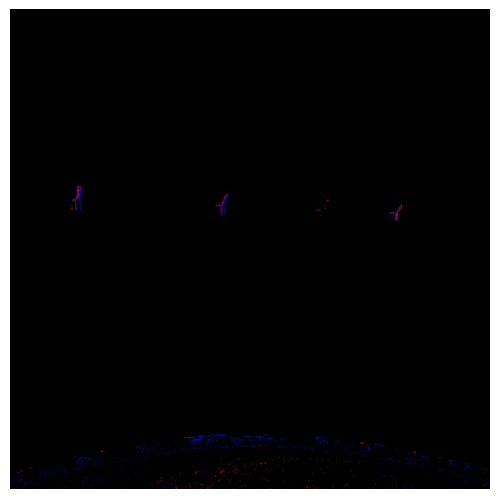

In [7]:
# Test image

test_images_size_tups[:5], test_images[0].shape, test_images[0].max()

for img in test_images[:5]:
    plt.imshow(img)
    plt.axis('off')
    plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
    plt.show()

# Test with different methods

## Using effcientdet lite2-detector

In [8]:
effdet2_model = hub.KerasLayer("https://kaggle.com/models/tensorflow/efficientdet/frameworks/tensorflow2/variations/lite2-detection/versions/1")

Image index: 26
Time stamp : 1.12 s No. of objects: 4
Detection Coordinates: [(561, 337, 581, 377), (91, 330, 109, 373), (342, 334, 356, 375), (753, 352, 773, 381)]


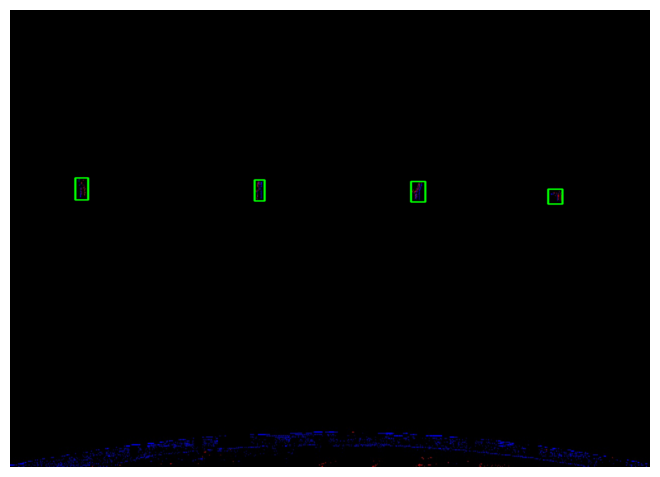

In [26]:
# Test image

index = 26
print("Image index:", index)

sample_image_t = tf.constant(test_images[index], dtype=tf.uint8)
sample_image_t = tf.expand_dims(sample_image_t, axis=0)
image_np = sample_image_t.numpy()

boxes, scores, classes, num_detections = effdet2_model(image_np)

image_np = image_np[0]

img, objects, box_list = get_annotated_img_objects(image_np, boxes[0], scores[0], num_detections[0])

time_stamp = frame_index_to_time_stamp(index+1, fps)

print("Time stamp :", round(time_stamp,2), "s","No. of objects:", objects)

print ("Detection Coordinates:", box_list)

# Reshape the image to the desired dimensions
# Specify the new dimensions
new_width = 1400
new_height = 1000
img = resize(img, (new_height, new_width))


plt.imshow(img)
plt.axis('off')
plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
plt.show()

# # Create a directory to save the plots if it doesn't exist
# output_folder = "results/"
# if not os.path.exists(output_folder):
#     os.makedirs(output_folder)

# plt.savefig(output_folder + str(index) + '_effdet2_result.png')


## Using effcientdet lite3-detector

In [10]:
effdet3_model = hub.KerasLayer("https://kaggle.com/models/tensorflow/efficientdet/frameworks/tensorflow2/variations/lite3-detection/versions/1")

Image index: 26
Time stamp : 1.12 s No. of objects: 4
Detection Coordinates: [(342, 335, 356, 373), (560, 337, 578, 375), (756, 356, 775, 380), (569, 880, 587, 892)]


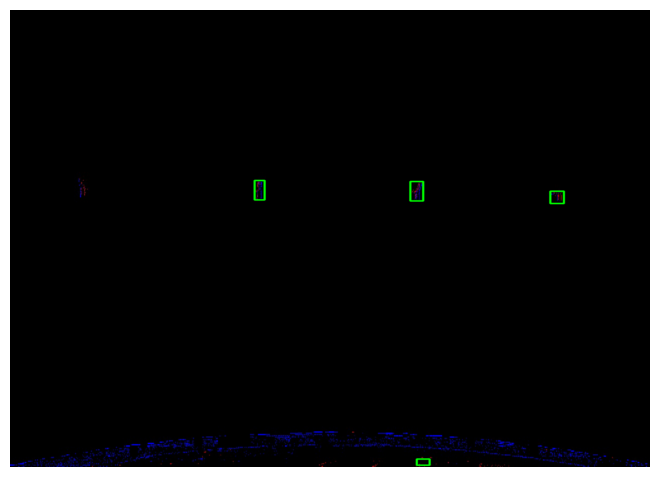

In [25]:
# Test image

index = 26
print("Image index:", index)

sample_image_t = tf.constant(test_images[index], dtype=tf.uint8)
sample_image_t = tf.expand_dims(sample_image_t, axis=0)
image_np = sample_image_t.numpy()

boxes, scores, classes, num_detections = effdet3_model(image_np)

image_np = image_np[0]

img, objects, box_list = get_annotated_img_objects(image_np, boxes[0], scores[0], num_detections[0])

time_stamp = frame_index_to_time_stamp(index+1, fps)

print("Time stamp :", round(time_stamp,2), "s","No. of objects:", objects)

print ("Detection Coordinates:", box_list)


# Reshape the image to the desired dimensions
# Specify the new dimensions
new_width = 1400
new_height = 1000
img = resize(img, (new_height, new_width))


plt.imshow(img)
plt.axis('off')
plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
plt.show()

# # Create a directory to save the plots if it doesn't exist
# output_folder = "results/"
# if not os.path.exists(output_folder):
#     os.makedirs(output_folder)

# plt.savefig(output_folder + str(index) + '_effdet3_result.png')

# Apply effcientdet lite2-detector to all and generate detection coordinates

Time stamp : 0.04 s No. of objects: 4
Detection Coordinates: [(382, 344, 403, 386), (111, 326, 134, 380), (569, 352, 600, 398), (711, 360, 741, 398)]
Time stamp : 0.08 s No. of objects: 3
Detection Coordinates: [(120, 326, 141, 382), (391, 346, 413, 390), (706, 363, 732, 399)]
Time stamp : 0.12 s No. of objects: 4
Detection Coordinates: [(378, 343, 396, 385), (105, 326, 126, 379), (569, 348, 596, 394), (720, 359, 747, 395)]
Time stamp : 0.17 s No. of objects: 4
Detection Coordinates: [(378, 342, 396, 383), (571, 348, 596, 392), (721, 357, 747, 396), (103, 326, 126, 378)]
Time stamp : 0.21 s No. of objects: 3
Detection Coordinates: [(385, 347, 407, 390), (113, 327, 136, 379), (703, 363, 734, 399)]
Time stamp : 0.25 s No. of objects: 4
Detection Coordinates: [(381, 343, 402, 386), (108, 326, 131, 381), (717, 358, 763, 395), (568, 349, 600, 396)]
Time stamp : 0.29 s No. of objects: 3
Detection Coordinates: [(120, 326, 141, 382), (391, 346, 413, 390), (706, 363, 732, 399)]
Time stamp : 0.3

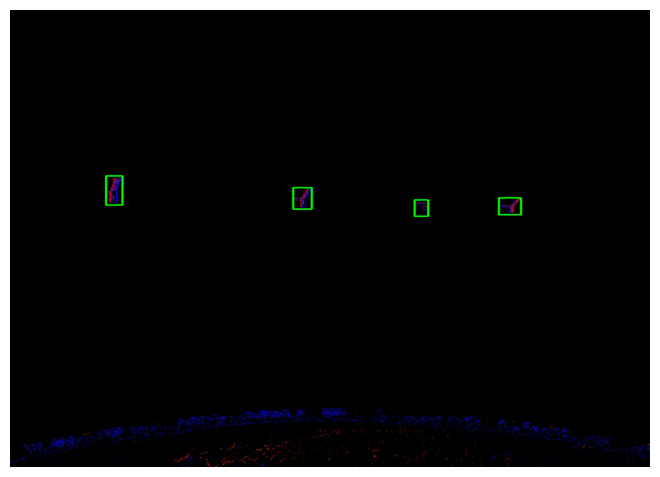

In [12]:
# Specify the output file path
output_file_path = "detection_coordinates.txt"

for index in range(len(test_images)):

    sample_image_t = tf.constant(test_images[index], dtype=tf.uint8)
    sample_image_t = tf.expand_dims(sample_image_t, axis=0)
    image_np = sample_image_t.numpy()

    boxes, scores, classes, num_detections = effdet2_model(image_np)

    image_np = image_np[0]

    img, objects, box_list = get_annotated_img_objects(image_np, boxes[0], scores[0], num_detections[0])
    time_stamp = frame_index_to_time_stamp(index+1, fps)

    print("Time stamp :", round(time_stamp,2), "s","No. of objects:", objects)
    print ("Detection Coordinates:", box_list)

    # Write the list to the text file
    with open(output_file_path, "a") as output_file:

        output_file.write("Time stamp: {}s No. of satellites: {}\n".format(round(time_stamp,2), objects))
        output_file.write(f"Detection Coordinates: {box_list}\n")


    # Reshape the image to the desired dimensions
    # Specify the new dimensions
    new_width = 1400
    new_height = 1000
    img = resize(img, (new_height, new_width))
    
    plt.imshow(img)
    plt.axis('off')
    plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
    # plt.show()
    

    # Create a directory to save the plots if it doesn't exist
    output_folder = "results/"
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    plt.savefig(output_folder + str(index) + '_effdet2_result.png')


# Create video from image detection results

In [13]:
# Create Video from results

!video-fromimg --input-files "results/*.png" --fps 24 Eventcamera_detection.mp4

{'fps': 24,
 'input_files': 'results/*.png',
 'nframes': None,
 'out_file': 'Eventcamera_detection.mp4'}
Eventcamera_detection.mp4: 100%|████████████████| 96/96 [00:01<00:00, 51.54it/s]
